In [192]:
import pandas as pd
import numpy  as np
from random import randint
import matplotlib.pyplot as plt

PATH = '/home/tbrownex/data/Hackett/JLP/'

In [193]:
# "pos" is the current position
# "movement" is where he's going
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

In [194]:
def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

In [195]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

In [196]:
def gaussian_repr(self):
    return '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(self[0], self[1])

from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = gaussian_repr

In [197]:
# Create Train and Test sets
# Train on all but the last month of data; then test against the last month
# "train" is a series; "test" is a single value
def split(sales, n):
    train = sales[:-n]
    test  = sales.tail(n)
    test  = test.iloc[0]
    return train, test

In [198]:
def createPM(sales, var):
    start  = sales.iloc[0]
    finish = sales.iloc[-1]
    rate   = (finish-start)/len(sales)
    return gaussian(rate, var)

In [199]:
cols = ["Store", "Week", "Sales"]
df = pd.read_csv(PATH+"/UseCase1/salesForecast/store_sales_by_OLG-pre.csv",\
                 names=cols, header=0)

df["Sales"] = df["Sales"].astype("float")

In [200]:
# Given a week, predict next weeks' sales and compare with a baseline prediction
# The baseline would be if your prediction was just last weeks' sales
# "sales" is a series holding the sales, week by week
# "var" is the variance to be fed into the Process Model
# Return the prediction error for both Bayesian and simple predictor
def processSales(sales, n, var):
    sales, test = split(sales, n)
    baseline  = sales.iloc[-1]   # Used as simplistic predictor
    # Initialize the Prior
    x = gaussian(sales.iloc[0], var)
    process_model = createPM(sales, var)
    # Set the variance of the "Sensor" to the actual variance
    sensorVar  = sales.var()
    priors = []
    xs     = []
    for z in sales:
        prior      = predict(x, process_model)
        likelihood = gaussian(z, sensorVar)
        x = update(prior, likelihood)
        priors.append(prior.mean)
        xs.append(x.mean)
    pred = x.mean
    baseDiff = abs(baseline - test)
    predDiff = abs(pred - test)
    
    
    plt.plot(sales)
    #plt.plot(priors)
    plt.plot(xs)
    plt.show()
    return baseDiff, predDiff

In [201]:
# For each week, predict next weeks' sales
# Return a list holding all the predictions, used to compute accuracy
def loopWeeks(var):
    base = []
    pred = []
    for n in weeks:
        baseDiff, predDiff = processSales(sales, n, var)
        base.append(baseDiff)
        pred.append(predDiff)
    return base, pred

Variance	Improvement


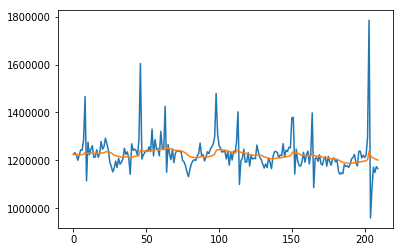

20,000,000     -16.8%


In [202]:
sales = df.groupby("Week")["Sales"].sum()
sales = sales.reset_index(drop=True)

# These are all the weeks we'll be processing
weeks = [x for x in range(10, 110)]
weeks = [20]

print("Variance\tImprovement")
#for var in [100000*x for x in range(1,100)]:
for var in [20000000]:
    base, pred = loopWeeks(var)
    accuracy = (sum(base) - sum(pred))/sum(base)
    #if accuracy > .143:
    print("{:<15,.0f}{:.1%}".format(var, accuracy))